In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

In [3]:
user_views_per_stream_df = pd.read_csv("data/user_views_per_stream.csv", header=0)
user_views_per_stream_df.head()

,USERID,STREAMID,num_views,day_of_week,time_labeled,num_cards,views_per_card
0,245,163,1029,Wednesday,Afternoon,15,68.600000
1,245,167,258,Thursday,Afternoon,14,18.428571
2,245,171,123,Wednesday,Afternoon,6,20.500000
3,245,172,83,Wednesday,Afternoon,4,20.750000
4,245,173,167,Monday,Afternoon,8,20.875000


In [4]:
unique_users = np.unique(user_views_per_stream_df["USERID"].values)
unique_users.shape

(219,)

In [5]:
unique_streams = np.unique(user_views_per_stream_df["STREAMID"].values)
unique_streams.shape
num_unique_streams = unique_streams.shape[0]
num_unique_streams

153

In [6]:
stream_views_grouped_stream_df = pd.read_csv("../../nudge_framework/generated/stream_views_grouped_stream.csv", header=0)
stream_views_grouped_user_df = pd.read_csv("../../nudge_framework/generated/stream_views_grouped_user.csv", header=0)
stream_views_grouped_stream_df.head()

,STREAMID,time_concatenated,total_num_views,day_of_week,time_labeled,day_of_week_conf,time_labelled_conf
0,163,1345.566799,1759,Wednesday,Afternoon,0.312109,0.371802
1,167,1528.027076,554,Thursday,Afternoon,0.442238,0.323105
2,171,1278.251046,239,Wednesday,Afternoon,0.418410,0.209205
3,172,1339.262032,187,Thursday,Afternoon,0.331551,0.251337
4,173,1314.365729,391,Thursday,Afternoon,0.309463,0.355499


In [7]:
stream_views_grouped_user_df.head()

,USERID,time_concatenated,total_num_views,day_of_week,time_labeled,day_of_week_conf,time_labelled_conf
0,245,1567.501350,4075,Thursday,Afternoon,0.314110,0.275092
1,246,1704.980989,263,Thursday,Evening,0.802281,0.068441
2,247,1256.211226,677,Wednesday,Afternoon,0.392910,0.267356
3,248,1389.285714,21,Wednesday,Afternoon,0.714286,0.714286
4,249,1401.199070,1075,Thursday,Afternoon,0.282791,0.214884


In [9]:
actual_user_views_df = pd.read_csv("../../nudge_framework/generated/stream_views_grouped_by_userid_streamid.csv", header=0)
actual_user_views_df.head()

,USERID,STREAMID,time_concatenated,total_num_views,day_of_week,time_labeled
0,245,163,1414.703596,1029,Wednesday,Afternoon
1,245,167,1633.251938,258,Thursday,Evening
2,245,171,1419.065041,123,Wednesday,Afternoon
3,245,172,1486.048193,83,Wednesday,Afternoon
4,245,173,1482.485030,167,Monday,Afternoon


## Baseline

G:\anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


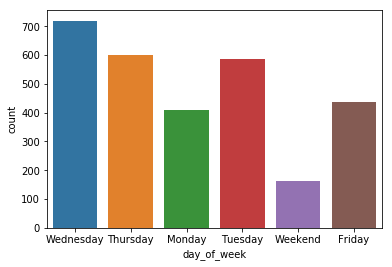

In [37]:
import seaborn as sns
sns.countplot(x="day_of_week", data=actual_user_views_df)

In [39]:
actual_user_views_df[actual_user_views_df["day_of_week"] == "Wednesday"].shape[0]/actual_user_views_df.shape[0]

0.2464861158724717

### So, baseline for day of week is 0.24, if we always predict the most common day of week

G:\anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


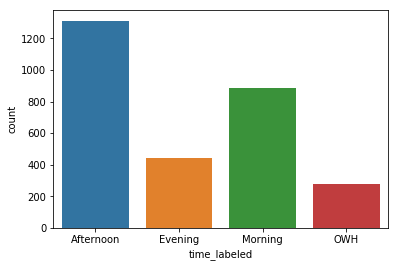

In [38]:
import seaborn as sns
sns.countplot(x="time_labeled", data=actual_user_views_df)

In [40]:
actual_user_views_df[actual_user_views_df["time_labeled"] == "Afternoon"].shape[0]/actual_user_views_df.shape[0]

0.4494343503599589

### So, baseline for time of day is 0.44, if we always predict the most common time of day

In [13]:
def predict_day_time_for_nudge(userid, streamid, choose_best=True):
    # get the details from the user df
    user_df = stream_views_grouped_user_df[stream_views_grouped_user_df["USERID"] == userid]
    
    # get the details from the stream df
    stream_df = stream_views_grouped_stream_df[stream_views_grouped_stream_df["STREAMID"] == streamid]
    
    if user_df.empty and stream_df.empty:
        return None, None, None
    elif user_df.empty:
        return stream_df["day_of_week"].values[0], stream_df["time_labeled"].values[0], stream_df
    elif stream_df.empty:
        return user_df["day_of_week"].values[0], user_df["time_labeled"].values[0], user_df
    else:
        
        if choose_best:
            user_day_of_week_conf = user_df["day_of_week_conf"].values[0]
            stream_day_of_week_conf = stream_df["day_of_week_conf"].values[0]
            day_to_recommend = user_df["day_of_week"].values[0]
            if stream_day_of_week_conf > user_day_of_week_conf:
                day_to_recommend = stream_df["day_of_week"].values[0]

            user_time_conf = user_df["time_labelled_conf"].values[0]
            stream_time_conf = stream_df["time_labelled_conf"].values[0]
            time_to_recommend = user_df["time_labeled"].values[0]
            if stream_time_conf > user_time_conf:
                time_to_recommend = stream_df["time_labeled"].values[0]
        else:
            day_to_recommend_by_stream = stream_df["day_of_week"].values[0]
            day_to_recommend_by_user = user_df["day_of_week"].values[0]
            
            time_to_recommend_by_stream = user_df["time_labeled"].values[0]
            time_to_recommend_by_user = stream_df["time_labeled"].values[0]
            
            day_to_recommend = (day_to_recommend_by_stream, day_to_recommend_by_user)
            time_to_recommend = (time_to_recommend_by_stream, time_to_recommend_by_user)
            
        return day_to_recommend, time_to_recommend, None

## Predict nudge based on combination

In [21]:
nudge_predictions_time_of_day = []
nudge_predictions_day = []

for itr in [10, 15, 20, 25, 30, 40, 50]:
    correct_time_of_day_ratio = 0
    correct_day_ratio = 0    
    for jtr in range(10): 
        correct_time_of_day = 0
        correct_day = 0
        selected_users = np.random.choice(unique_users, itr, False)
        selected_streams = np.random.choice(unique_streams, itr, False)
        streams_actually_viewed = 0
        for userid in selected_users:
            for streamid in selected_streams:
                predicted_day, predicted_time, _ = predict_day_time_for_nudge(userid, streamid)
                actual_day_df = actual_user_views_df[(actual_user_views_df["USERID"] == userid) & (actual_user_views_df["STREAMID"] == streamid)]
                actual_time_df = actual_user_views_df[(actual_user_views_df["USERID"] == userid) & (actual_user_views_df["STREAMID"] == streamid)]
                
                # user has not viewed the stream in reality
                if (predicted_day is None) or (actual_day_df.empty) or (actual_time_df.empty):
                    continue
                    
                actual_day = actual_day_df["day_of_week"].values[0]
                actual_time = actual_time_df["time_labeled"].values[0]
                streams_actually_viewed += 1
                if predicted_day == actual_day:
                    correct_day += 1
                if predicted_time == actual_time:
                    correct_time_of_day += 1
        
        correct_time_of_day_ratio += (correct_time_of_day)/streams_actually_viewed
        correct_day_ratio += (correct_day)/streams_actually_viewed
        
    nudge_predictions_time_of_day.append((itr, correct_time_of_day_ratio/10))
    nudge_predictions_day.append((itr, correct_day_ratio/10))

In [22]:
nudge_predictions_time_of_day

[(10, 0.542027417027417),
 (15, 0.6125134732255475),
 (20, 0.5689716224695751),
 (25, 0.5929216766172142),
 (30, 0.6035193830837902),
 (40, 0.5934453862620188),
 (50, 0.5887080901552156)]

In [23]:
nudge_predictions_day

[(10, 0.46551226551226554),
 (15, 0.3945670117063306),
 (20, 0.4878701576295791),
 (25, 0.5056695496587341),
 (30, 0.5168131160570277),
 (40, 0.5113464255254546),
 (50, 0.5061315729048752)]

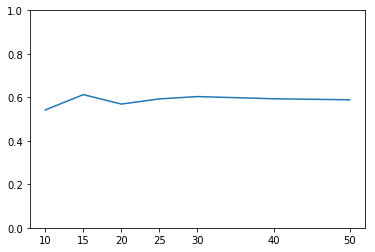

In [24]:
x = [nudge_prediction_time_of_day[0] for nudge_prediction_time_of_day in nudge_predictions_time_of_day]
y = [nudge_prediction_time_of_day[1] for nudge_prediction_time_of_day in nudge_predictions_time_of_day]

plt.xticks(x)
plt.ylim(ymin=0)
plt.plot(x, y)

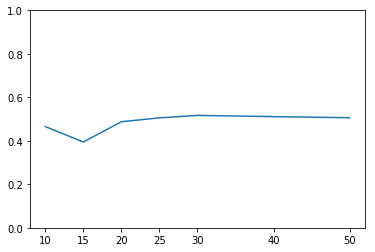

In [25]:
x = [nudge_prediction_day[0] for nudge_prediction_day in nudge_predictions_day]
y = [nudge_prediction_day[1] for nudge_prediction_day in nudge_predictions_day]

plt.xticks(x)
plt.ylim(ymin=0)
plt.plot(x, y)

## Predict nudge based on user preferences alone

In [27]:
nudge_predictions_time_of_day = []
nudge_predictions_day = []

for itr in [10, 15, 20, 25, 30, 40, 50]:
    correct_time_of_day_ratio = 0
    correct_day_ratio = 0    
    for jtr in range(10): 
        correct_time_of_day = 0
        correct_day = 0
        selected_users = np.random.choice(unique_users, itr, False)
        selected_streams = np.random.choice(unique_streams, itr, False)
        streams_actually_viewed = 0
        for userid in selected_users:
            for streamid in selected_streams:
                predicted_day, predicted_time, _ = predict_day_time_for_nudge(userid, streamid, False)
                actual_day_df = actual_user_views_df[(actual_user_views_df["USERID"] == userid) & (actual_user_views_df["STREAMID"] == streamid)]
                actual_time_df = actual_user_views_df[(actual_user_views_df["USERID"] == userid) & (actual_user_views_df["STREAMID"] == streamid)]
                
                # user has not viewed the stream in reality
                if (predicted_day is None) or (actual_day_df.empty) or (actual_time_df.empty):
                    continue
                
                predicted_day = predicted_day[1]
                predicted_time = predicted_time[1]
                
                actual_day = actual_day_df["day_of_week"].values[0]
                actual_time = actual_time_df["time_labeled"].values[0]
                streams_actually_viewed += 1
                if predicted_day == actual_day:
                    correct_day += 1
                if predicted_time == actual_time:
                    correct_time_of_day += 1
        
        correct_time_of_day_ratio += (correct_time_of_day)/streams_actually_viewed
        correct_day_ratio += (correct_day)/streams_actually_viewed
        
    nudge_predictions_time_of_day.append((itr, correct_time_of_day_ratio/10))
    nudge_predictions_day.append((itr, correct_day_ratio/10))

In [28]:
nudge_predictions_time_of_day

[(10, 0.5274825174825175),
 (15, 0.45790578597030207),
 (20, 0.4762548653735267),
 (25, 0.46340607508452286),
 (30, 0.4645488035506129),
 (40, 0.4474149688264891),
 (50, 0.4696397971274167)]

In [29]:
nudge_predictions_day

[(10, 0.5560839160839162),
 (15, 0.5203942652329749),
 (20, 0.5113538426864999),
 (25, 0.48126746060167847),
 (30, 0.4579198627900422),
 (40, 0.4766588309329893),
 (50, 0.47361026247112986)]

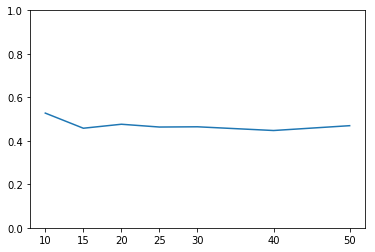

In [30]:
x = [nudge_prediction_time_of_day[0] for nudge_prediction_time_of_day in nudge_predictions_time_of_day]
y = [nudge_prediction_time_of_day[1] for nudge_prediction_time_of_day in nudge_predictions_time_of_day]

plt.xticks(x)
plt.ylim(ymin=0)
plt.plot(x, y)

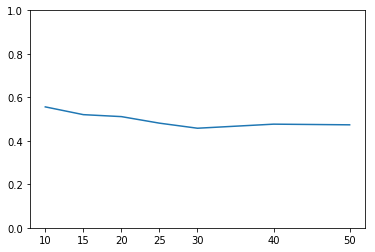

In [31]:
x = [nudge_prediction_day[0] for nudge_prediction_day in nudge_predictions_day]
y = [nudge_prediction_day[1] for nudge_prediction_day in nudge_predictions_day]

plt.xticks(x)
plt.ylim(ymin=0)
plt.plot(x, y)

## Predict nudge based on stream preferences alone

In [32]:
nudge_predictions_time_of_day = []
nudge_predictions_day = []

for itr in [10, 15, 20, 25, 30, 40, 50]:
    correct_time_of_day_ratio = 0
    correct_day_ratio = 0    
    for jtr in range(10): 
        correct_time_of_day = 0
        correct_day = 0
        selected_users = np.random.choice(unique_users, itr, False)
        selected_streams = np.random.choice(unique_streams, itr, False)
        streams_actually_viewed = 0
        for userid in selected_users:
            for streamid in selected_streams:
                predicted_day, predicted_time, _ = predict_day_time_for_nudge(userid, streamid, False)
                actual_day_df = actual_user_views_df[(actual_user_views_df["USERID"] == userid) & (actual_user_views_df["STREAMID"] == streamid)]
                actual_time_df = actual_user_views_df[(actual_user_views_df["USERID"] == userid) & (actual_user_views_df["STREAMID"] == streamid)]
                
                # user has not viewed the stream in reality
                if (predicted_day is None) or (actual_day_df.empty) or (actual_time_df.empty):
                    continue
                
                predicted_day = predicted_day[0]
                predicted_time = predicted_time[0]
                
                actual_day = actual_day_df["day_of_week"].values[0]
                actual_time = actual_time_df["time_labeled"].values[0]
                streams_actually_viewed += 1
                if predicted_day == actual_day:
                    correct_day += 1
                if predicted_time == actual_time:
                    correct_time_of_day += 1
        
        correct_time_of_day_ratio += (correct_time_of_day)/streams_actually_viewed
        correct_day_ratio += (correct_day)/streams_actually_viewed
        
    nudge_predictions_time_of_day.append((itr, correct_time_of_day_ratio/10))
    nudge_predictions_day.append((itr, correct_day_ratio/10))

In [33]:
nudge_predictions_time_of_day

[(10, 0.5915207015207016),
 (15, 0.5897396463185938),
 (20, 0.6008180172081101),
 (25, 0.5727819341036103),
 (30, 0.6068106558407246),
 (40, 0.6092291850093752),
 (50, 0.5999533508402335)]

In [34]:
nudge_predictions_day

[(10, 0.3034459984459984),
 (15, 0.291956990378043),
 (20, 0.25626213226058425),
 (25, 0.31387604373931327),
 (30, 0.3304096524049936),
 (40, 0.3331105828274177),
 (50, 0.32030453124212765)]

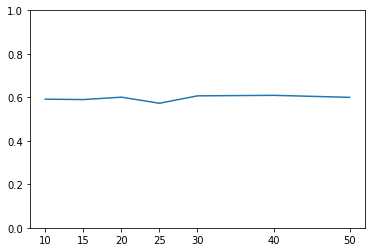

In [35]:
x = [nudge_prediction_time_of_day[0] for nudge_prediction_time_of_day in nudge_predictions_time_of_day]
y = [nudge_prediction_time_of_day[1] for nudge_prediction_time_of_day in nudge_predictions_time_of_day]

plt.xticks(x)
plt.ylim(ymin=0)
plt.plot(x, y)

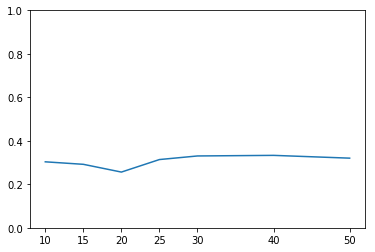

In [36]:
x = [nudge_prediction_day[0] for nudge_prediction_day in nudge_predictions_day]
y = [nudge_prediction_day[1] for nudge_prediction_day in nudge_predictions_day]

plt.xticks(x)
plt.ylim(ymin=0)
plt.plot(x, y)